# Load Igor-exported HDF5 data

In [1]:
from analyz.IO import hdf5
from datavyz import graph_env_notebook as ge
import numpy as np

In [2]:
fn = 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm18Sep2019c1/nm18Sep2019c1_000_ctrl.h5'

In [3]:
data = hdf5.load_dict_from_hdf5(fn)

In [199]:
import string

def reshape_data_from_Igor(data, dt_subsampling=1):
    """
    dt_subampling in [ms]
    """
    new_data = {'recording_type':''}
    new_data['original_dt'] = data['SampleInterval']
    isubsampling = 1 #max([1, int(dt_subsampling/new_data['original_dt'])])
    new_data['dt'] = new_data['original_dt']/isubsampling # in ms
    nsample = int(data['SamplesPerWave'])
    new_data['t'] = new_data['original_dt']*np.arange(nsample)[::isubsampling]
    # nchannels = data['NMPrefix_Record']['NumChannels'] # useless
    # nepisodes = data['NMPrefix_Record']['NumWaves'] # useless
    
    ##############################################
    ## Find the key of the protocol --> MORE TO FIND IN THAT protocol_key quantity
    for key in data:
        if (type(data[key]) is dict) and ('BoardConfigs' in data[key]):
            protocol_data = data[key]
            
    ##############################################
    ## Read the "BoardConfig" of the protocol and build the 'recording' and 'stimulation' outputs
    #
    # read recording info
    VRC = np.isfinite(protocol_data['BoardConfigs']['ADCboard']) # valid recording channels
    rec_channels = protocol_data['BoardConfigs']['ADCchan'][VRC]
    rec_names = protocol_data['BoardConfigs']['ADCname'][VRC]
    new_data['rec_units'] = protocol_data['BoardConfigs']['ADCunits'][VRC]
    print('Recordings channels:')
    for i, name in enumerate(rec_names):
        print('- %i) %s' % (i, name))
        print('Record%s0' % string.ascii_uppercase[i])
        new_data[name] = []
        for key in data['NMPrefix_Record']['ChanWaveNames%s'%string.ascii_uppercase[i]]:
            new_data[name].append(data[key][::isubsampling])
        new_data[name] = np.array(new_data[name])
    #
    # read stimulation info
    VSC = np.isfinite(protocol_data['BoardConfigs']['DACboard']) # valid stimulation channels
    stim_channels = protocol_data['BoardConfigs']['DACchan'][VSC]
    stim_names = protocol_data['BoardConfigs']['DACname'][VSC]
    stim_gain = protocol_data['BoardConfigs']['DACscale'][VSC]
    #print(protocol_data['BoardConfigs'])
    new_data['stim_units'] = protocol_data['BoardConfigs']['DACunits'][VSC]
    print('Stimulation channels:')
    for i, name in enumerate(stim_names):
        print('- %i) %s' % (i, name))
        if 'DAC_%i_1' % i in protocol_data:
            protocol_data[name] = []
            j=0
            while 'DAC_%i_%i' % (i,j) in protocol_data: # we loop over episodes
                new_data[name].append(stim_gain[i]*protocol_data['DAC_%i_%i' % (i,j)][::isubsampling])
                j+=1
        else:
            new_data[name] = stim_gain[i]*protocol_data['DAC_%i_0' % i][::isubsampling] # just one array
    #
    ##############################################

    if 'CT_RecordMode' in data:
        if data['CT_RecordMode']==1:
            new_data['recording_type']='voltage-clamp'
        elif data['CT_RecordMode']==1:
            new_data['recording_type']='current-clamp'
            
    return new_data

def remove_stimulation_artefact(D):
    # now blanking the stimulus period
    cond = (D['Stimulator']>1)
    D['Irecording_clean'] = 1.*D['Irecording']
    for i in range(D['Irecording'].shape[0]):
        D['Irecording_clean'][i,:][cond] = D['Irecording'][i,:][-1]
    return D

def load_data_exported_from_Igor(filename, dt_subsampling=0.1):
    data = hdf5.load_dict_from_hdf5(filename)
    new_data = reshape_data_from_Igor(data, dt_subsampling=dt_subsampling)
    new_data = remove_stimulation_artefact(new_data)
    new_data['filename'] = filename
    return new_data

In [200]:
load_data_exported_from_Igor(fn1, dt_subsampling=0.1)

Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator


{'recording_type': 'voltage-clamp',
 'original_dt': 0.01,
 'dt': 0.01,
 't': array([0.00000e+00, 1.00000e-02, 2.00000e-02, ..., 3.49997e+03,
        3.49998e+03, 3.49999e+03]),
 'rec_units': array(['nA'], dtype=object),
 'Irecording': array([[0.21805216, 0.21998417, 0.21998417, ..., 0.23737224, 0.23801624,
         0.23672823],
        [0.21805216, 0.21612015, 0.21354414, ..., 0.22964421, 0.2277122 ,
         0.22320418],
        [0.23286422, 0.23350822, 0.23028821, ..., 0.21869616, 0.21418814,
         0.21161213],
        ...,
        [0.23286422, 0.23286422, 0.23737224, ..., 0.24123625, 0.23350822,
         0.22964421],
        [0.22384818, 0.22384818, 0.22642419, ..., 0.23286422, 0.23157621,
         0.2290002 ],
        [0.23994825, 0.23994825, 0.23737224, ..., 0.22513619, 0.23157621,
         0.23479623]]),
 'stim_units': array(['mV', 'V'], dtype=object),
 'Vcommand': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'Stimulator': array([-1.1705197e-08, -5.4969860e-09,  6.708

In [186]:

def plot_protocol(D):
    fig, AX = ge.figure(axes_extents=[[[3,1]] for i in range(3)]+[[[3,3]]], hspace=0.3, figsize=(1,.6))
    ge.title(AX[0], D['filename'])
    ge.plot(1e-3*D['t'], D['Vcommand'], ax=AX[0], axes_args={'spines':['left'], 'ylabel':'Vcmd (mV)'})
    ge.plot(1e-3*D['t'], D['Stimulator'], ax=AX[1], axes_args={'spines':['left'], 'ylabel':'Stim (V)'})
    for i in range(D['Irecording'].shape[0]):
        AX[2].plot(1e-3*D['t'], D['Irecording'][i,:], color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'], D['Irecording'].mean(axis=0), ax=AX[2],
            axes_args={'spines':['left'], 'ylabel':'raw I (nA)'})
    # now blanking the stimulus period
    cond = (D['Stimulator']>1)
    for i in range(D['Irecording'].shape[0]):
        AX[3].plot(1e-3*D['t'], D['Irecording_clean'][i,:], color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'], D['Irecording_clean'].mean(axis=0), ax=AX[3],
            axes_args={'xlabel':'time (s)', 'ylabel':'Stim (V)'})

def protocol_comparison(DATA,
                        labels=['Control', 'Tricine'],
                        colors=['k', ge.green]):
    fig, AX = ge.figure(axes=(1,3), figsize=(2,1.3), hspace=0.3)
    for data, c in zip(DATA, colors):
        AX[0].plot(1e-3*data['t'], data['Irecording'].mean(axis=0), color=c)
    ge.set_plot(AX[0], ['left'], ylabel='raw-I (nA)')

    for data, label, c in zip(DATA, labels, colors):
        tcond = (data['t']>250)
        baseline_cond = (data['t']>300) & (data['t']<390)
        baseline = data['Irecording_clean'].mean(axis=0)[baseline_cond].mean()
        trace = data['Irecording_clean'].mean(axis=0)[tcond]-baseline
        
        AX[1].plot(1e-3*data['t'][tcond], trace, color=c, label=label)
        AX[2].plot(1e-3*data['t'][tcond], trace/trace.max(), color=c, label=label)
        
    ge.set_plot(AX[1], ['left'], ylabel='I (nA)\n (-baseline&stim)')
    ge.set_plot(AX[2], xlabel='time (s)', ylabel='I (nA)\n (-baseline&stim)\n (+rescaled)')
    
    ge.legend(AX[1])
    return fig, AX
    
    

In [163]:
fn1 = 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm18Sep2019c1/nm18Sep2019c1_000_ctrl.h5'
data_ctrl = load_data_exported_from_Igor(fn1, dt_subsampling=0.1)
fn2 = 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm18Sep2019c1/nm18Sep2019c1_001_tricine.h5'
data_tricine = load_data_exported_from_Igor(fn2, dt_subsampling=0.1)

Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator


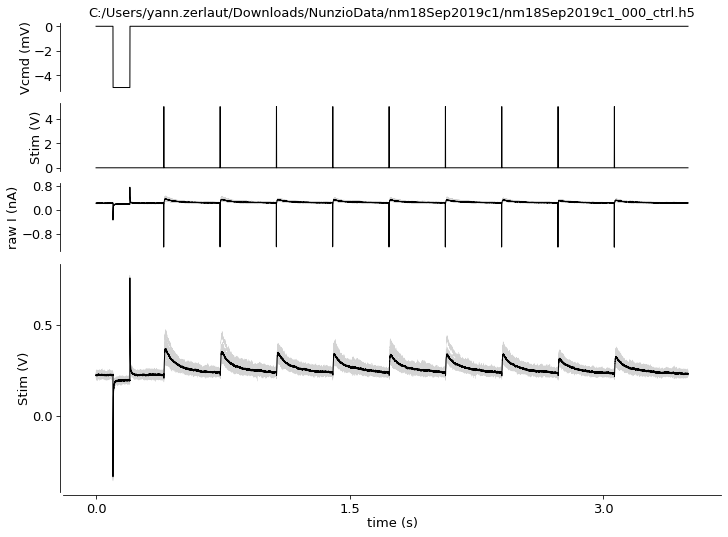

In [164]:
plot_protocol(data_ctrl)

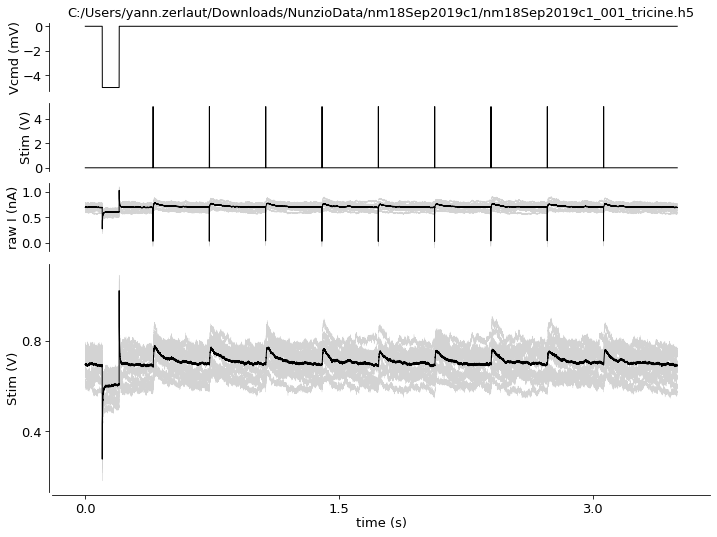

In [154]:
plot_protocol(data_tricine)

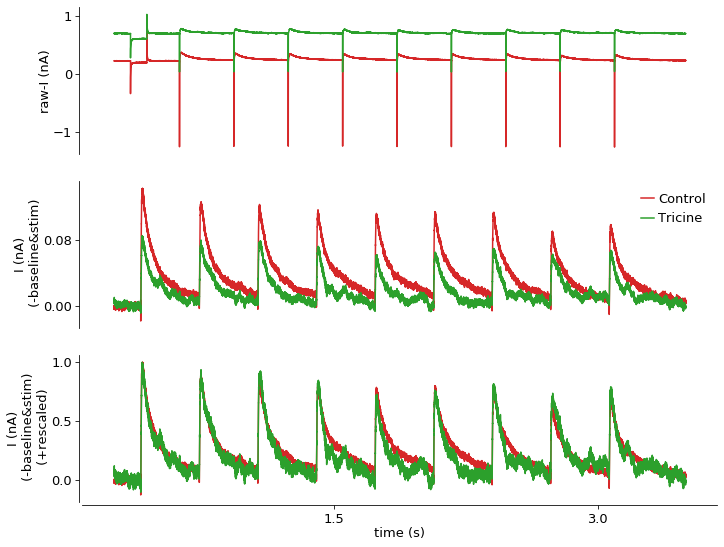

In [188]:
_ = protocol_comparison([data_ctrl, data_tricine], colors=[ge.red, ge.green], labels=['Control', 'Tricine'])

In [201]:
CTRLS, TRICINES = [], []
import os
root_path = "C:/Users/yann.zerlaut/Downloads/NunzioData/"
for d in os.listdir(root_path):
    for ff in os.listdir(os.path.join(root_path, d)):
        if ff.endswith('_ctrl.h5'):
            CTRLS.append(os.path.join(root_path, d, ff))
        if ff.endswith('_tricine.h5'):
            TRICINES.append(os.path.join(root_path, d, ff))

Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
Recordings channels:

IndexError: boolean index did not match indexed array along dimension 0; dimension is 400000 but corresponding boolean dimension is 350000

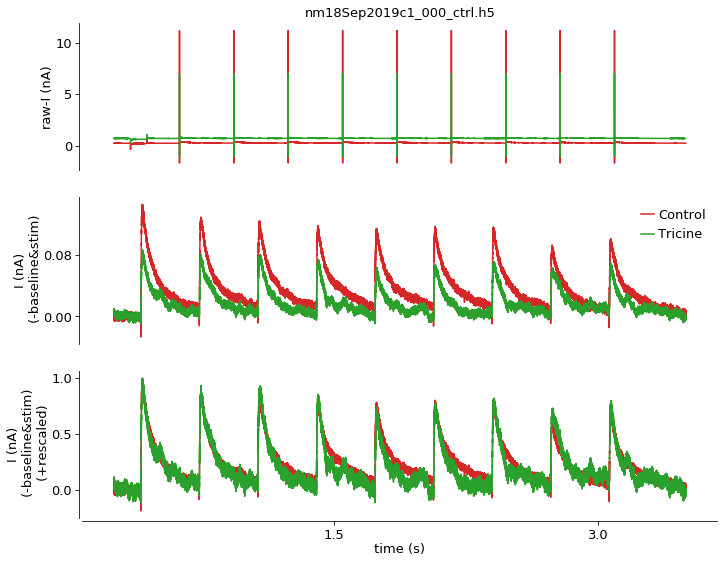

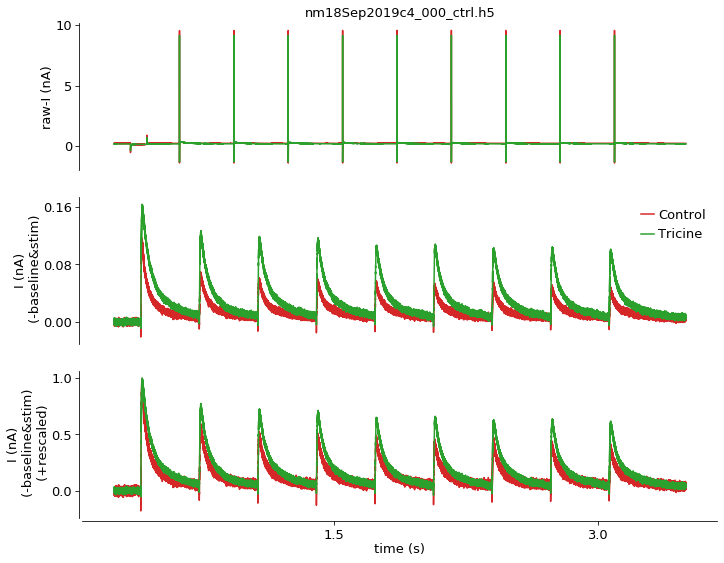

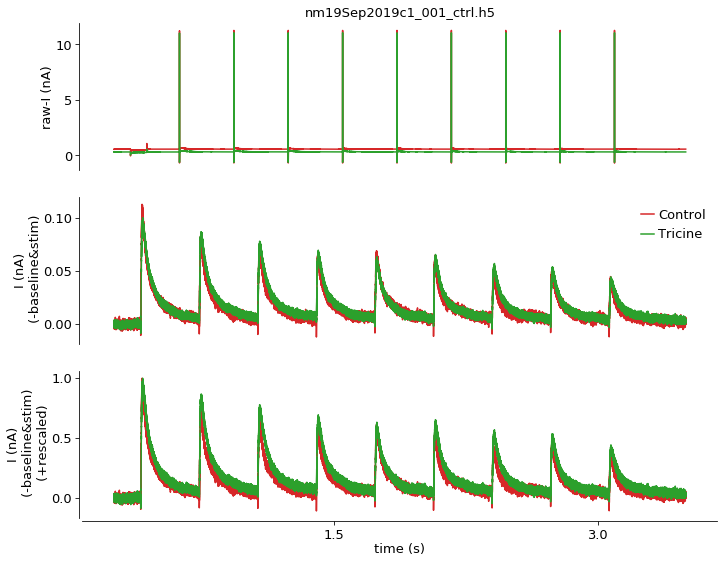

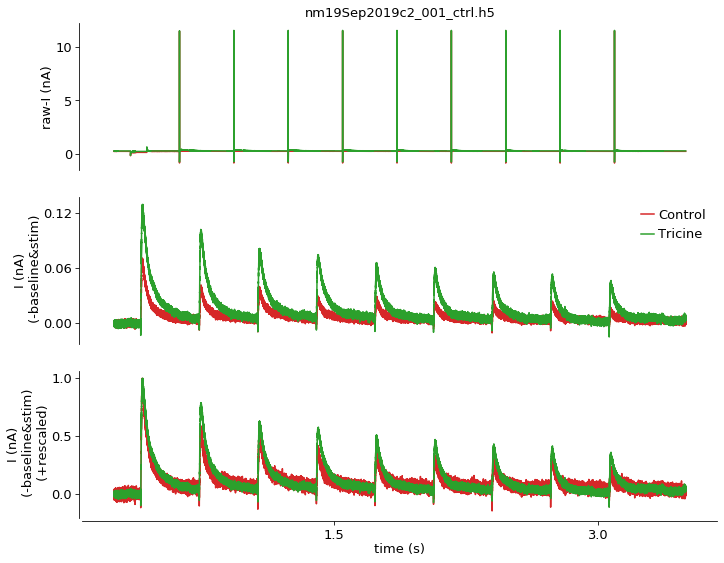

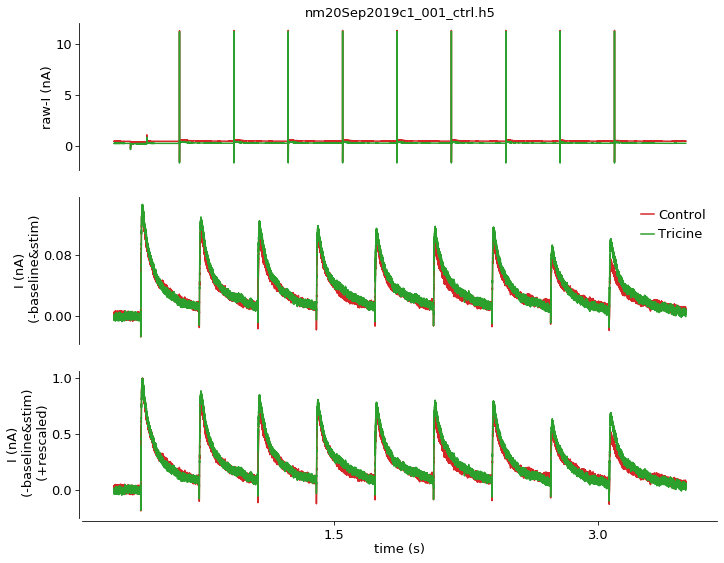

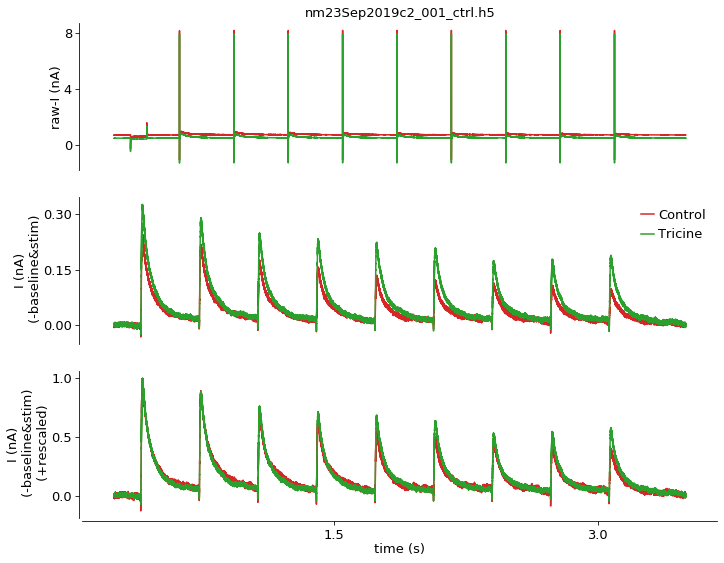

In [202]:
for fn_ctrl, fn_tricine in zip(CTRLS, TRICINES):
    data_ctrl = load_data_exported_from_Igor(fn_ctrl, dt_subsampling=0.01)
    data_tricine = load_data_exported_from_Igor(fn_tricine, dt_subsampling=0.01)
    fig, AX = protocol_comparison([data_ctrl, data_tricine],
                                  colors=[ge.red, ge.green], labels=['Control', 'Tricine'])
    ge.title(AX[0], fn_ctrl.split('\\')[-1])

In [192]:
CTRLS

['C:/Users/yann.zerlaut/Downloads/NunzioData/nm18Sep2019c1\\nm18Sep2019c1_000_ctrl.h5',
 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm18Sep2019c4\\nm18Sep2019c4_000_ctrl.h5',
 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm19Sep2019c1\\nm19Sep2019c1_001_ctrl.h5',
 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm19Sep2019c2\\nm19Sep2019c2_001_ctrl.h5',
 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm20Sep2019c1\\nm20Sep2019c1_001_ctrl.h5',
 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm23Sep2019c2\\nm23Sep2019c2_001_ctrl.h5',
 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm30Aug2019c0\\nm30Aug2019c0_000_ctrl.h5']

In [193]:
fn = 'C:/Users/yann.zerlaut/Downloads/NunzioData/nm30Aug2019c0\\nm30Aug2019c0_000_ctrl.h5'

In [195]:
data_ctrl = load_data_exported_from_Igor(fn)

Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator


IndexError: boolean index did not match indexed array along dimension 0; dimension is 40000 but corresponding boolean dimension is 35000

In [196]:
def remove_stimulation_artefact(D):
    # now blanking the stimulus period
    cond = (D['Stimulator']>1)
    D['Irecording_clean'] = 1.*D['Irecording']
    for i in range(D['Irecording'].shape[0]):
        D['Irecording_clean'][i,:][cond] = D['Irecording'][i,:][-1]
    return D

def load_data_exported_from_Igor(filename, dt_subsampling=0.1):
    data = hdf5.load_dict_from_hdf5(filename)
    new_data = reshape_data_from_Igor(data, dt_subsampling=dt_subsampling)
    #new_data = remove_stimulation_artefact(new_data)
    new_data['filename'] = filename
    return new_data
data_ctrl = load_data_exported_from_Igor(fn)

Recordings channels:
- 0) Irecording
RecordA0
Stimulation channels:
- 0) Vcommand
- 1) Stimulator
